# Ref
- [statsmodels](https://www.statsmodels.org/stable/index.html)

# 断点回归

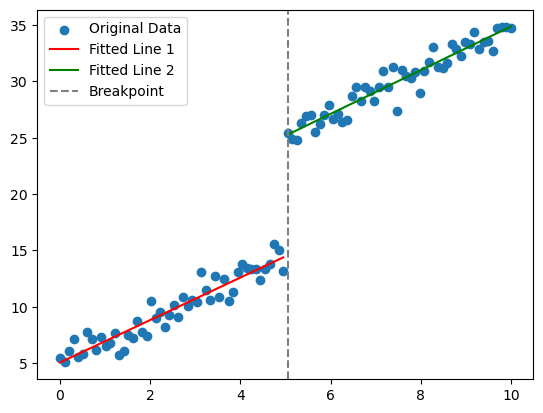

In [4]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 创建模拟数据
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 2 * x + 5 + np.random.normal(0, 1, size=len(x))

# 在 x=5 处添加一个结构性断点
y[50:] = y[50:] + 10

# 获取断点的位置
breakpoint_index = 50
breakpoint_value = x[breakpoint_index]

# 将数据分为两个区间
x1 = x[:breakpoint_index]
y1 = y[:breakpoint_index]
x2 = x[breakpoint_index:]
y2 = y[breakpoint_index:]

# 拟合断点左侧的回归模型
X1 = sm.add_constant(x1)
model1 = sm.OLS(y1, X1)
results1 = model1.fit()

# 拟合断点右侧的回归模型
X2 = sm.add_constant(x2)
model2 = sm.OLS(y2, X2)
results2 = model2.fit()

# 计算每个区间的拟合值
y_fit1 = results1.predict(X1)
y_fit2 = results2.predict(X2)

# 绘制原始数据和回归线
plt.scatter(x, y, label='Original Data')
plt.plot(x1, y_fit1, 'r-', label='Fitted Line 1')
plt.plot(x2, y_fit2, 'g-', label='Fitted Line 2')
plt.axvline(x=breakpoint_value, color='gray', linestyle='--', label='Breakpoint')
plt.legend()
plt.show()


# 双重差分

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 生成示例数据
np.random.seed(42)

# 创建一个面板数据框架
panel_data = pd.DataFrame({
    'id': np.repeat(range(1, 6), 5),
    'time': np.tile(range(1, 6), 5),
    'treatment': np.random.randint(0, 2, size=25),
    'outcome': np.random.randn(25)
})

# 添加固定效应和时间效应
panel_data['fixed_effect'] = np.random.randn(25)
panel_data['time_effect'] = np.random.randn(25)

# 创建因果效应
panel_data['causal_effect'] = 0.5 * panel_data['treatment'] + 0.8 * panel_data['time_effect']

# 添加因果效应到因变量上
panel_data['outcome'] = panel_data['outcome'] + panel_data['causal_effect']

# 实现双重差分
def double_difference(data, treatment_col, time_col, outcome_col):
    # 对固定效应和时间效应进行差分
    data['diff_fixed_effect'] = data.groupby('id')['fixed_effect'].transform(lambda x: x - x.mean())
    data['diff_time_effect'] = data.groupby('time')['time_effect'].transform(lambda x: x - x.mean())

    # 对因变量和因果效应进行差分
    data['diff_outcome'] = data.groupby('id')[outcome_col].transform(lambda x: x - x.shift(1))
    data['diff_causal_effect'] = data.groupby('id')['causal_effect'].transform(lambda x: x - x.shift(1))

    # 构建差分模型
    model = sm.OLS(data['diff_outcome'], sm.add_constant(data[['diff_fixed_effect', 'diff_time_effect', treatment_col]]))
    results = model.fit()

    # 打印回归结果
    print(results.summary())

# 应用双重差分
double_difference(panel_data, 'treatment', 'time', 'outcome')


                            OLS Regression Results                            
Dep. Variable:           diff_outcome   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 04 Dec 2023   Prob (F-statistic):                nan
Time:                        19:29:30   Log-Likelihood:                    nan
No. Observations:                  25   AIC:                               nan
Df Residuals:                      21   BIC:                               nan
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                    nan        na

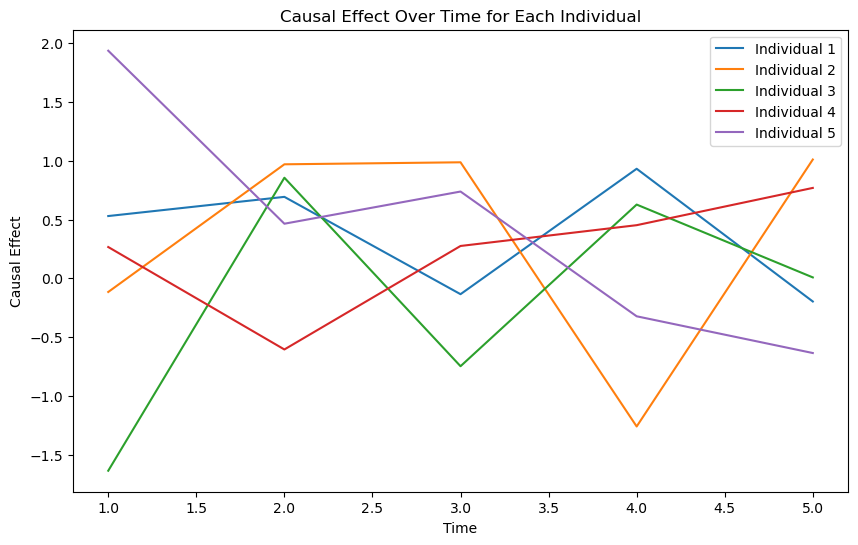

In [3]:
import matplotlib.pyplot as plt

# 画出因果效应的示意图
plt.figure(figsize=(10, 6))

# 按照时间绘制每个个体的因果效应
for individual_id in range(1, 6):
    individual_data = panel_data[panel_data['id'] == individual_id]
    plt.plot(individual_data['time'], individual_data['causal_effect'], label=f'Individual {individual_id}')

plt.xlabel('Time')
plt.ylabel('Causal Effect')
plt.title('Causal Effect Over Time for Each Individual')
plt.legend()
plt.show()


In [6]:
import meta



# 工具变量法

In [2]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

# 示例数据（简化示例）
data = pd.DataFrame({
    'income': [50000, 52000, 48000, 51000, 53000, 49000],
    'education': [12, 14, 11, 13, 15, 12],
    'ability': [90, 95, 85, 92, 96, 88],  # 潜在的遗漏变量
    'distance': [10, 5, 15, 7, 3, 12],     # 工具变量
})

# 添加常数项
data['const'] = 1


In [3]:

# OLS 估计（可能有偏）
ols_model = sm.OLS(data['income'], data[['const', 'education']])
ols_result = ols_model.fit()
print("OLS结果：\n", ols_result.summary())


OLS结果：
                             OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     99.41
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           0.000568
Time:                        04:27:31   Log-Likelihood:                -43.414
No. Observations:                   6   AIC:                             90.83
Df Residuals:                       4   BIC:                             90.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.451e+04   1612.745     21.397 

e:\Program Files\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [4]:

# IV 回归（工具变量法）
iv_model = IV2SLS.from_formula(
    'income ~ 1 + [education ~ distance]',
    data
)
iv_result = iv_model.fit()
print("\nIV结果（2SLS）：\n", iv_result.summary)



IV结果（2SLS）：
                           IV-2SLS Estimation Summary                          
Dep. Variable:                 income   R-squared:                      0.9596
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9495
No. Observations:                   6   F-statistic:                    271.17
Date:                Wed, Jun 11 2025   P-value (F-stat)                0.0000
Time:                        04:27:34   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept   3.383e+04     1049.3     32.241     0.0000   3.177e+04   3.589e+04
education      1299.0     78.882     1

<strong style="color:red;">模型基本信息</strong>

| 指标                             | 含义        | 解读                                                                 |
| ------------------------------ | --------- | ------------------------------------------------------------------ |
| **Dep. Variable**              | 因变量       | `income`，目标是解释收入变化                                                 |
| **Estimator**                  | 使用的估计方法   | `IV-2SLS`（两阶段最小二乘法）                                                |
| **No. Observations**           | 样本数       | 6，仍然很小，结果需谨慎解读                                                     |
| **R-squared / Adj. R-squared** | 决定系数      | **0.9596 / 0.9495**，模型拟合度仍然很高（几乎和 OLS 一样）                          |
| **F-statistic**                | 第一阶段强度检验  | **271.17**，非常高，说明工具变量（distance）对解释变量（education）很有解释力，**没有弱工具变量问题** |
| **P-value (F-stat)**           | 工具变量显著性检验 | 0.0000，远小于 0.05，说明工具变量有效                                           |


<strong style="color:red;">参数估计解读（重点）</strong>

| 变量            | 系数估计       | 标准误    | t 值   | p 值    | 置信区间               | 解读                            |
| ------------- | ---------- | ------ | ----- | ------ | ------------------ | ----------------------------- |
| Intercept（截距） | **33830**  | 1049.3 | 32.24 | 0.0000 | (31770 \~ 35890)   | 没受教育时的基础收入估计值                 |
| education     | **1299.0** | 78.88  | 16.47 | 0.0000 | (1144.4 \~ 1453.6) | **每多一年教育 → 收入提升 \$1299**，显著正向 |


<strong style="color:red;">与 OLS 的对比</strong>

| 项目      | OLS       | IV-2SLS    | 解释                                     |
| ------- | --------- | ---------- | -------------------------------------- |
| 教育系数    | 1246.15   | **1299.0** | IV 估计稍高，说明 OLS 可能低估或高估了真实因果效应（取决于误差方向） |
| R²      | 0.961     | 0.9596     | 拟合度几乎一样                                |
| 教育系数显著性 | p = 0.001 | p = 0.0000 | 都非常显著                                  |


<strong style="color:red;">工具变量法使用是否合理？</strong>

| 条件              | 变量                     | 是否满足   | 说明                                         |
| --------------- | ---------------------- | ------ | ------------------------------------------ |
| **工具变量与解释变量相关** | distance 与 education   | ✅ 是    | F = 271.17，说明 distance 显著影响 education      |
| **工具变量与误差项无关**  | distance 与 income 的误差项 | ✅ 假设成立 | 这是 IV 方法的核心假设，无法直接检验，但理论合理（大学远近本身不会直接影响收入） |
